In [70]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import os
import cv2

from PSMNet.PSMNet import PSMNet
from utils.read_data import *

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [71]:
# left_path = '/home/lab1/datasets/DFC2019_track2_grayscale_8bit/Track2-RGB-1/JAX_022_011_004_LEFT_RGB.tif'
# right_path = '/home/lab1/datasets/DFC2019_track2_grayscale_8bit/Track2-RGB-1/JAX_022_011_004_RIGHT_RGB.tif'
# disp_path = '/home/lab1/datasets/DFC2019_track2_grayscale_8bit/Track2-RGB-1/JAX_022_011_004_LEFT_AGL.tif'
left_path = '/home/lab1/datasets/whu_stereo_8bit/with_ground_truth/train/left/QC_left_259.tiff'
right_path = '/home/lab1/datasets/whu_stereo_8bit/with_ground_truth/train/right/QC_right_259.tiff'
disp_path = '/home/lab1/datasets/whu_stereo_8bit/with_ground_truth/train/disp/QC_disparity_259.tiff'
# left_path = './img/JAX_004_009_007_LEFT_RGB.tif'
# right_path = './img/JAX_004_009_007_RIGHT_RGB.tif'
# disp_path = './img/JAX_004_009_007_LEFT_AGL.tif'

In [72]:
size = [1024, 1024]
img_l = Image.open(left_path)
img_l = img_l.resize(size)
img_l = np.array(img_l)
img_r = Image.open(right_path)
img_r = img_r.resize(size)
img_r = np.array(img_r)

tensor_l = img_norm(img_l)
tensor_r = img_norm(img_r)

tensor_l = tensor_l.unsqueeze(0).to(device)
tensor_r = tensor_r.unsqueeze(0).to(device)

print(tensor_l.shape)

torch.Size([1, 3, 1024, 1024])


9.800003 -23.886597


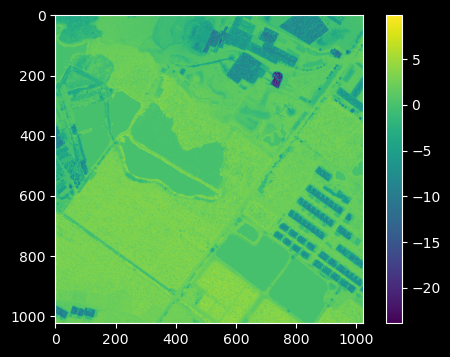

In [73]:
disp, valid = read_disp_whu(disp_path, size, -64, 64)
disp_tensor = torch.from_numpy(disp).float()
vaild_tensor = torch.from_numpy(valid).bool()
disp[~valid] = 0
print(disp.max(), disp.min())
fig = plt.figure(figsize=(6,4))
plt.figure(1)
im1 = plt.imshow(disp)
plt.colorbar(im1)
plt.show()

In [74]:
net = PSMNet()
net.load_state_dict(torch.load('./checkpoints/WHUStereo/5_epoch_PSMNet_WHUStereo.pth'), strict=True)
# net.eval()
net = net.to(device)


7.894166 -21.740429


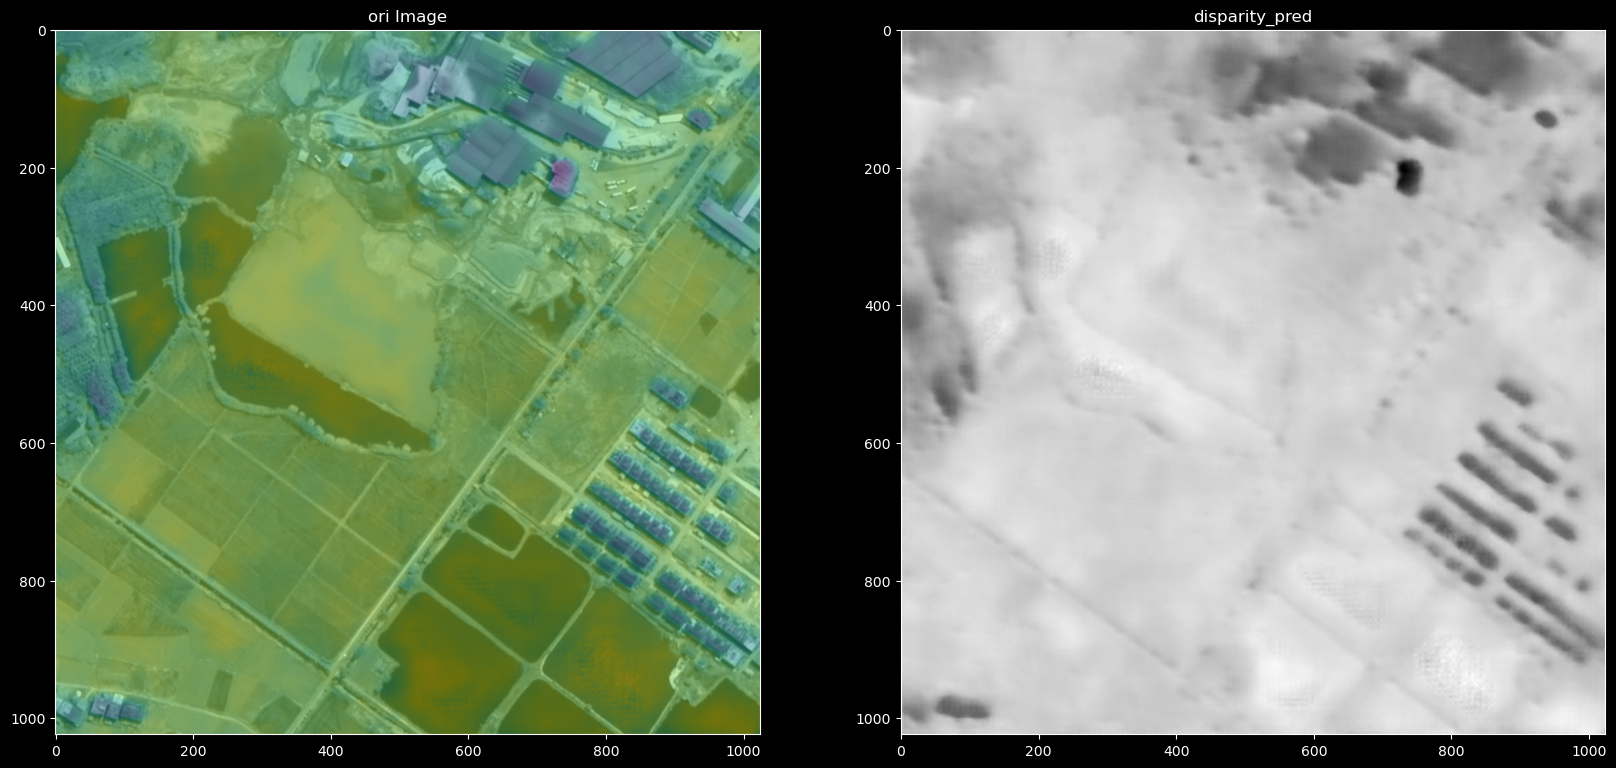

In [75]:
if net.training:
    with torch.no_grad():
        disp1, disp2, disp3 = net(tensor_l, tensor_r, -64, 64)
        disp3 = disp3.squeeze().cpu().numpy()
        print(disp3.max(), disp3.min())
else:
    with torch.no_grad():
        disp3 = net(tensor_l, tensor_r, -32, 64)
        disp3 = disp3.squeeze().cpu().numpy()
        print(disp3.max(), disp3.min())
#visualize
f, axis = plt.subplots(1, 2, figsize = (20,60))
axis[0].imshow(img_l)
axis[0].imshow(disp3, alpha=0.5)
axis[0].set_title('ori Image')
axis[1].imshow(disp3, cmap='gray')
axis[1].set_title('disparity_pred')
plt.show()

In [76]:
os.makedirs("demo_output", exist_ok=True)
cv2.imwrite('./demo_output/img.tif', disp3)

True